# Discovering Trends With Bucketing

Last tested version: <img src="https://img.shields.io/badge/Atoti-v0.8.9-blue">
   
This notebook shows how we can quickly and easily explore the results of different trading strategies in Atoti. We will see how we break down the trends by slicing the data with different bucketing criteria.

> In this Notebook:
> * Import Libraries
> * Instantiate the Atoti Session

💡 **Note:** In case you’re unable to see the Atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/atoti/blob/main/03-use-cases/01-finance/quantitative-strategy/bucket-analysis/main.ipynb).


## Import Libraries

In [1]:
import atoti as tt
import ipywidgets as widgets
from IPython.display import SVG, Markdown
from utils import data_model

## 1. Setting up the Atoti Cube

### 1.1. Instantiate the Atoti Session

When working with Atoti, we always start by instantiating an [Atoti Session](https://docs.atoti.io/latest/api/atoti.Session.html#atoti.Session). While we can explore data interactively in JupyterLab with Atoti, it's great to put together dashboards that allow us to systematically analyze the data. Therefore, we configure `user_content_storage` to persist any dashboards that we create in the session.

In addition, we can set control for [memory usage](https://docs.atoti.io/latest/deployment/deployment_setup.html#java-options) of the application via the `java_options` parameter.

In [2]:
session = tt.Session(
user_content_storage="./content", java_options=["-Xms1G", "-Xmx8G"], port=9092
)

### 1.2 Load Data and Create Atoti Cube

Once we have created the session, we can proceed to create our data model and create the multi-dimensional data cube. Below shows the key steps to perform data modeling. We have many examples showcasing the steps to create a cube in our notebook gallery, so we put these steps into a script. Refer to [data_model.py](utils/data_model.py) for the implementation.

<!-- <img src="https://data.atoti.io/notebooks/auto-cube/img/steps_to_bi_platform.gif" width="70%" />   -->


In [3]:
data_model.create_model(session)
txn_tbl = session.tables["Transaction"]
txn_tbl.head()

AccountSuffix  TransactionPrice  \
Ticker DateTime            TransactionId                                       
AAPL   2023-01-20 10:30:00 BS_AAPL0000004593         ACCT2        135.539993   
AMZN   2023-02-07 11:30:00 BB_AMZN0000012091         ACCT4         99.470001   
AAPL   2023-01-13 11:30:00 BS_AAPL0000006315         ACCT2        133.510101   
UNH    2023-01-27 09:30:00 BB_UNH0000064021          ACCT3        489.554993   
                           BB_UNH0000061342          ACCT4        489.554993   

                                               MAV_Strategy Action Strategy  \
Ticker DateTime            TransactionId                                      
AAPL   2023-01-20 10:30:00 BS_AAPL0000004593   MAV_close_30   Sell        B   
AMZN   2023-02-07 11:30:00 BB_AMZN0000012091      MAV_15_60    Buy        B   
AAPL   2023-01-13 11:30:00 BS_AAPL0000006315    MAV_close_5   Sell        B   
UNH    2023-01-27 09:30:00 BB_UNH0000064021    MAV_close_30    Buy        B   
                           BB_UNH0000061342   MAV_close_120    Buy        B   

                                                     PurchaseDate  \
Ticker DateTime            TransactionId                            
AAPL   2023-01-20 10:30:00 BS_AAPL0000004593  2023-01-20 09:30:00   
AMZN   2023-02-07 11:30:00 BB_AMZN0000012091  2023-02-07 11:30:00   
AAPL   2023-01-13 11:30:00 BS_AAPL0000006315  2023-01-13 10:30:00   
UNH    2023-01-27 09:30:00 BB_UNH0000064021   2023-01-27 09:30:00   
                           BB_UNH0000061342   2023-01-27 09:30:00   

                                              PurchasePrice  \
Ticker DateTime            TransactionId                      
AAPL   2023-01-20 10:30:00 BS_AAPL0000004593     135.050003   
AMZN   2023-02-07 11:30:00 BB_AMZN0000012091      99.470001   
AAPL   2023-01-13 11:30:00 BS_AAPL0000006315     133.029999   
UNH    2023-01-27 09:30:00 BB_UNH0000064021      489.554993   
                           BB_UNH0000061342      489.554993   

                                                  PurchaseTxnId       Date  \
Ticker DateTime            TransactionId                                     
AAPL   2023-01-20 10:30:00 BS_AAPL0000004593  BB_AAPL0000004598 2023-01-20   
AMZN   2023-02-07 11:30:00 BB_AMZN0000012091                N/A 2023-02-07   
AAPL   2023-01-13 11:30:00 BS_AAPL0000006315  BB_AAPL0000006320 2023-01-13   
UNH    2023-01-27 09:30:00 BB_UNH0000064021                 N/A 2023-01-27   
                           BB_UNH0000061342                 N/A 2023-01-27   

                                             Timestamp  
Ticker DateTime            TransactionId                
AAPL   2023-01-20 10:30:00 BS_AAPL0000004593  10:30:00  
AMZN   2023-02-07 11:30:00 BB_AMZN0000012091  11:30:00  
AAPL   2023-01-13 11:30:00 BS_AAPL0000006315  11:30:00  
UNH    2023-01-27 09:30:00 BB_UNH0000064021   09:30:00  
                           BB_UNH0000061342   09:30:00

### 1.3 Analyze the Cube Data Model

In [4]:
cube = session.cubes["TxnCube"]
session.tables.schema

```mermaid
erDiagram
  "Transaction" {
    _ String "AccountSuffix"
    _ String PK "Ticker"
    _ String PK "DateTime"
    nullable double "TransactionPrice"
    _ String "MAV_Strategy"
    _ String "Action"
    _ String "Strategy"
    _ String "PurchaseDate"
    nullable double "PurchasePrice"
    _ String "PurchaseTxnId"
    _ String PK "TransactionId"
    _ LocalDate "Date"
    _ String "Timestamp"
  }
```


## 2. Enriching the Atoti Cube

Before we see how bucketing is being used in our analysis, let's set up the order for our data and create the measures that we want to look at.

### 2.1 Assign Hierarchies, Levels, and Measures to Variables

In [5]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### 2.2. Ordering Timeseries  

Since we are unsure if the data loaded is ordered in the way we want, we can enforce the order we want.

There are two ways to perform [ordering](https://docs.atoti.io/latest/api/atoti.Level.order.html#atoti.Level.order) on members of a level:
1. [`NaturalOrder`](https://docs.atoti.io/latest/lib/atoti/atoti.order.natural_order.html) for ascending/descending order
2. [`CustomOrder`](https://docs.atoti.io/latest/lib/atoti/atoti.order.custom_order.html) based on a given ordered list for the first number of elements  

We set our timeseries in ascending order.

In [6]:
l["Date"].order = tt.NaturalOrder()
l["DateTime"].order = tt.NaturalOrder()
l["Timestamp"].order = tt.NaturalOrder()

### 2.3. Computing key performance metrics  

In this use case, we will focus on the realized PnL for the accounts along the time series.  
Given our data model, the realized PnL can be computed simply by:

$$ RealizedPnL = TransactionPrice - PurchasePrice $$

In order to focus only on the metrics that we want, we have created the cube in the `no_measures` mode. This means that other than the `contributors.COUNT`, no other measures are created. We will see in the subsequent sections how we create these measures.  

💡 **Note:** Refer to the [atoti.agg](https://docs.atoti.io/latest/api/atoti.agg.html) package for the available aggregation functions in Atoti. 

#### 2.3.1. Creating Measures from Tables

We can apply aggregation functions on a table column as shown below. 

In [7]:
txn_tbl = session.tables["Transaction"]

m["PurchasePrice.SUM"] = tt.agg.sum(txn_tbl["PurchasePrice"])
m["TransactionPrice.SUM"] = tt.agg.sum(txn_tbl["TransactionPrice"])

m["PurchasePrice"] = tt.agg.single_value(txn_tbl["PurchasePrice"])
m["TransactionPrice"] = tt.agg.single_value(txn_tbl["TransactionPrice"])

`PurchasePrice.SUM` and `TransactionPrice.SUM` are the equivalent of what the cube would have created automatically. Instead of summing up the purchase price and transaction price, we use `single_value` to return only the unique values. We can see at the `TransactionId` level, the `PurchasePrice` varies for different transactions. Therefore, no value is returned on the top level.

💡 **Note:** https://docs.atoti.io/latest/api/atoti.agg.single_value.html#atoti.agg.single_value

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
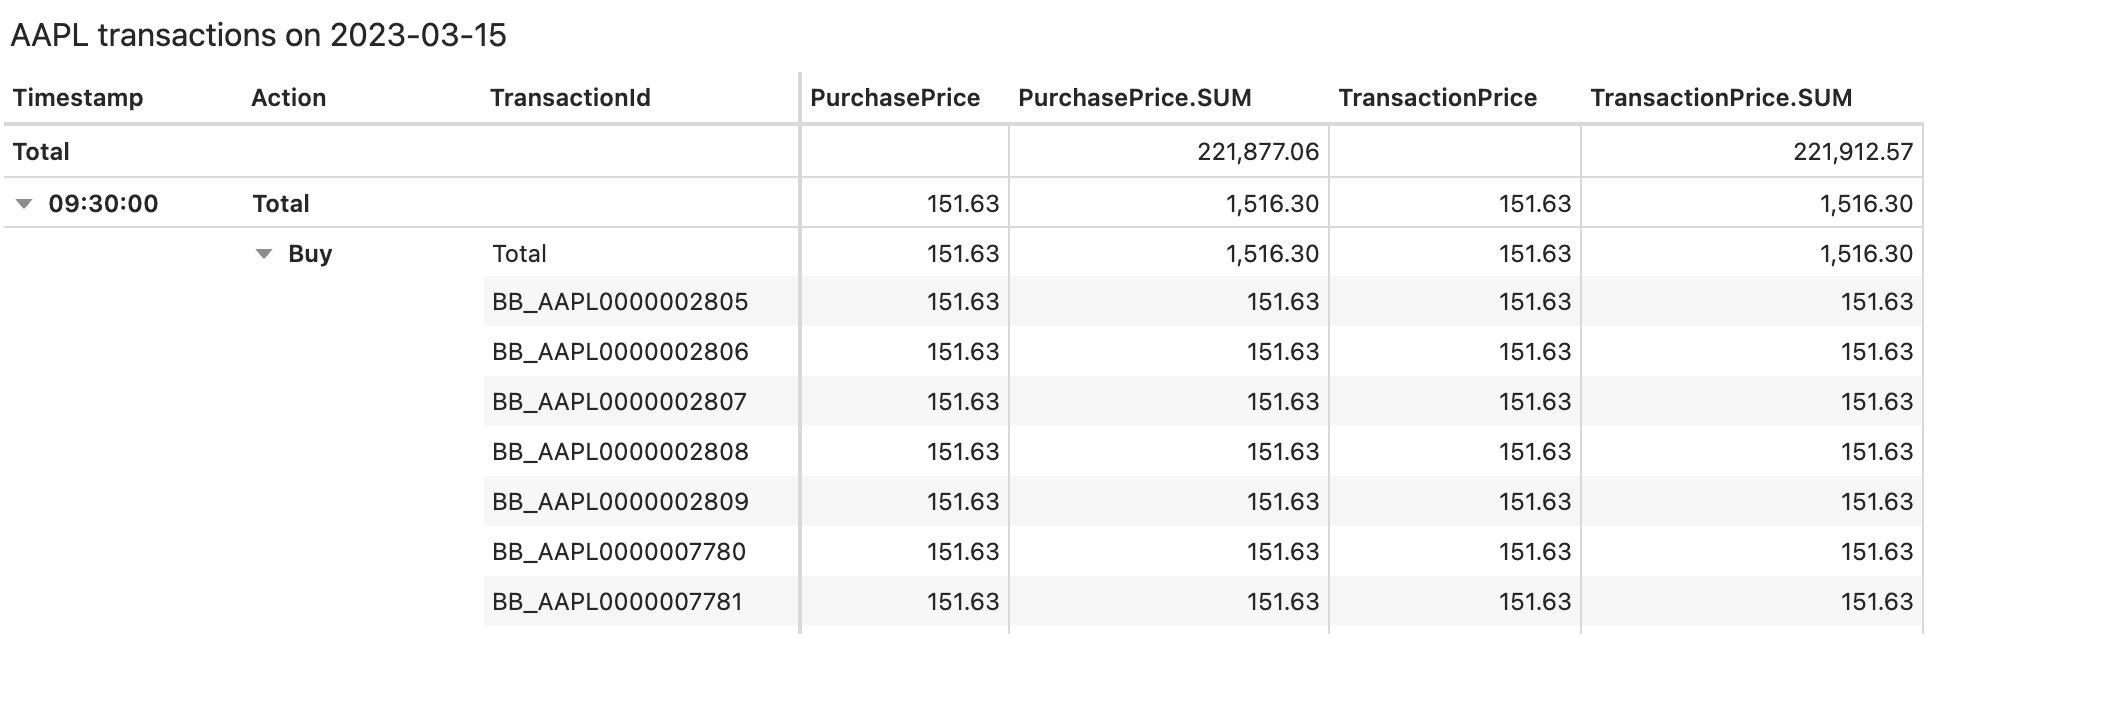

In [8]:
session.widget

#### 2.3.2. Compute realized PnL  

PnL is realized once the ticker is sold. Therefore, we can simply take the difference between the purchase price and transaction price when the transaction action is "Sell". This difference is performed at the `TransactionId` level, hence, we add it in the scope.

In addition, since we have a [conditional check](https://docs.atoti.io/latest/lib/atoti/atoti.function.where.html) on the `Action`, it has to be included in the scope as well.  

In [9]:
m["RealizedPnL"] = tt.agg.sum(
    tt.where(l["Action"] == "Sell", m["TransactionPrice"] - m["PurchasePrice"]),
    scope=tt.OriginScope(l["TransactionId"], l["Action"]),
)

#### 2.3.3. Cumulate realized PnL

We can cumulate the realized PnL along different levels, e.g. Date, DateTime and Timestamp. Remember to use the correct measure when querying along the different levels. 

In [10]:
m[f"Cum_Date_RealizedPnL"] = tt.agg.sum(
    m["RealizedPnL"], scope=tt.CumulativeScope(level=l["Date"])
)

m[f"Cum_DateTime_RealizedPnL"] = tt.agg.sum(
    m["RealizedPnL"], scope=tt.CumulativeScope(level=l["DateTime"])
)

m[f"Cum_Timestamp_RealizedPnL"] = tt.agg.sum(
    m["RealizedPnL"], scope=tt.CumulativeScope(level=l["Timestamp"])
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
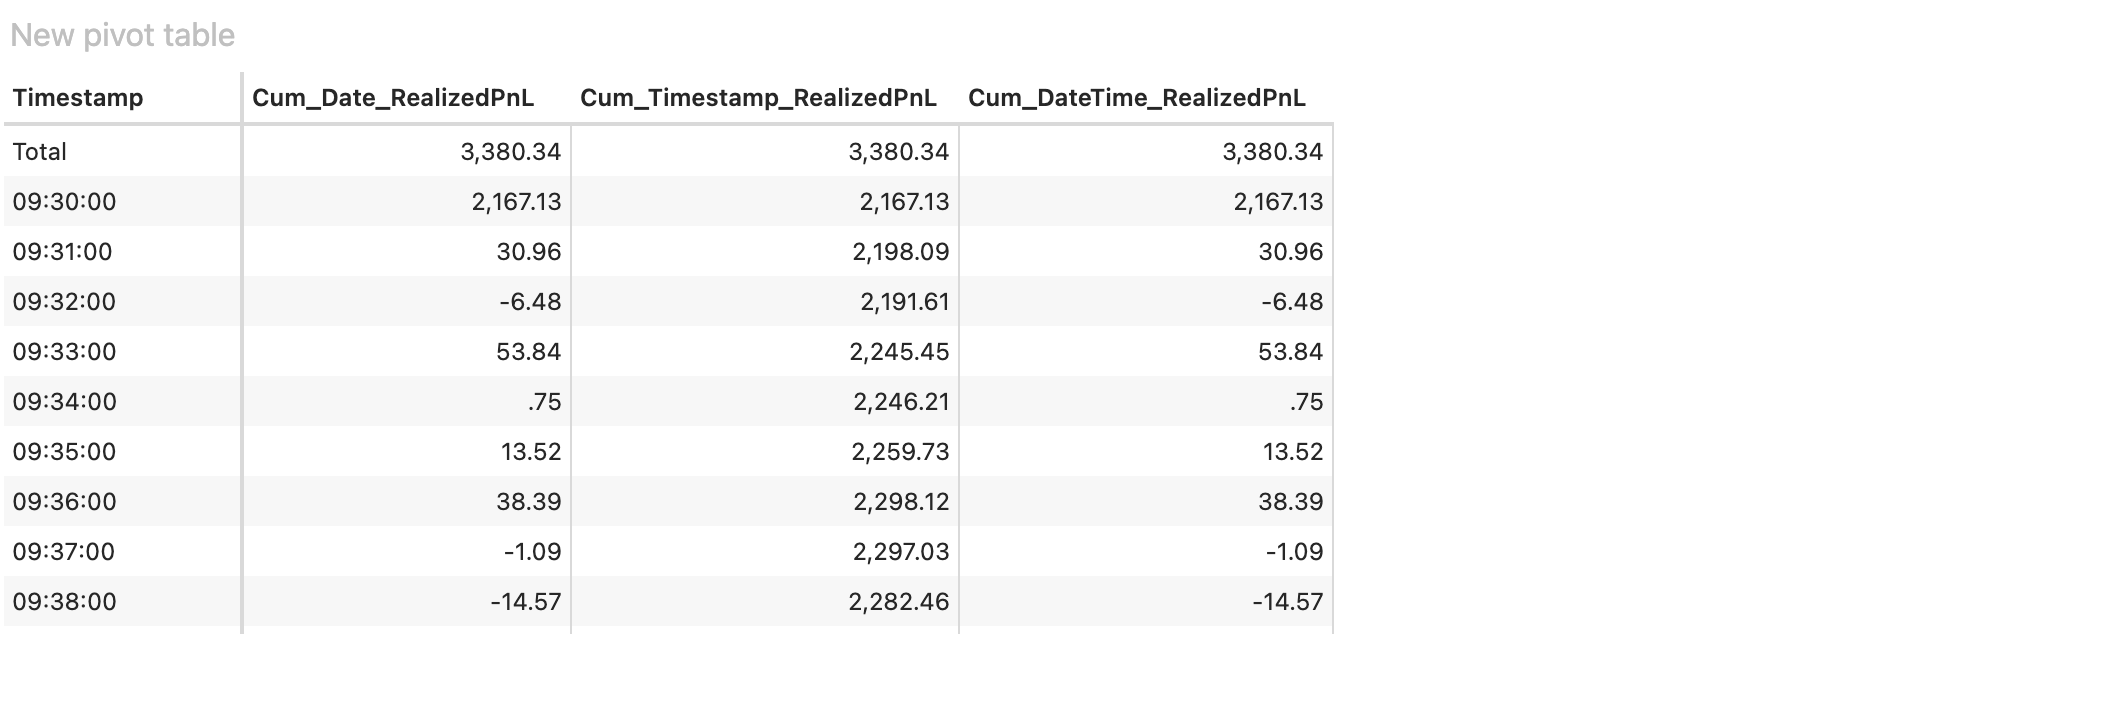

In [11]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
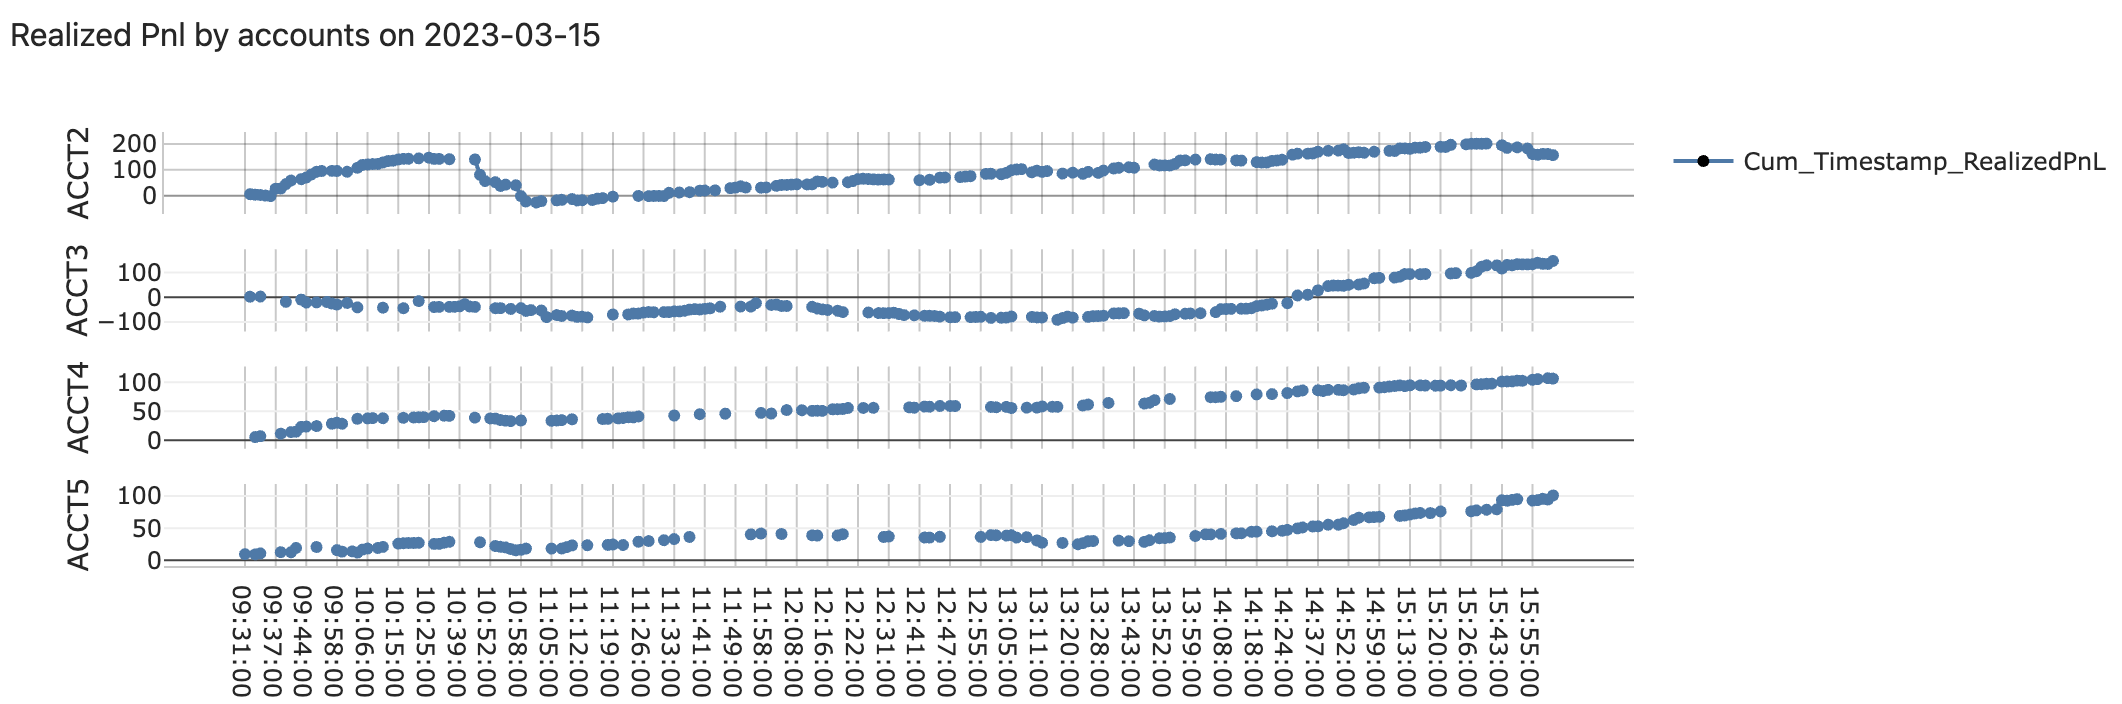

In [12]:
session.widget

Using subplot to visualize the PnL trend for each account, we can clearly see that `ACCT3` was making a loss for most part of the day. Let's dive a little more into the account to understand the loss better.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
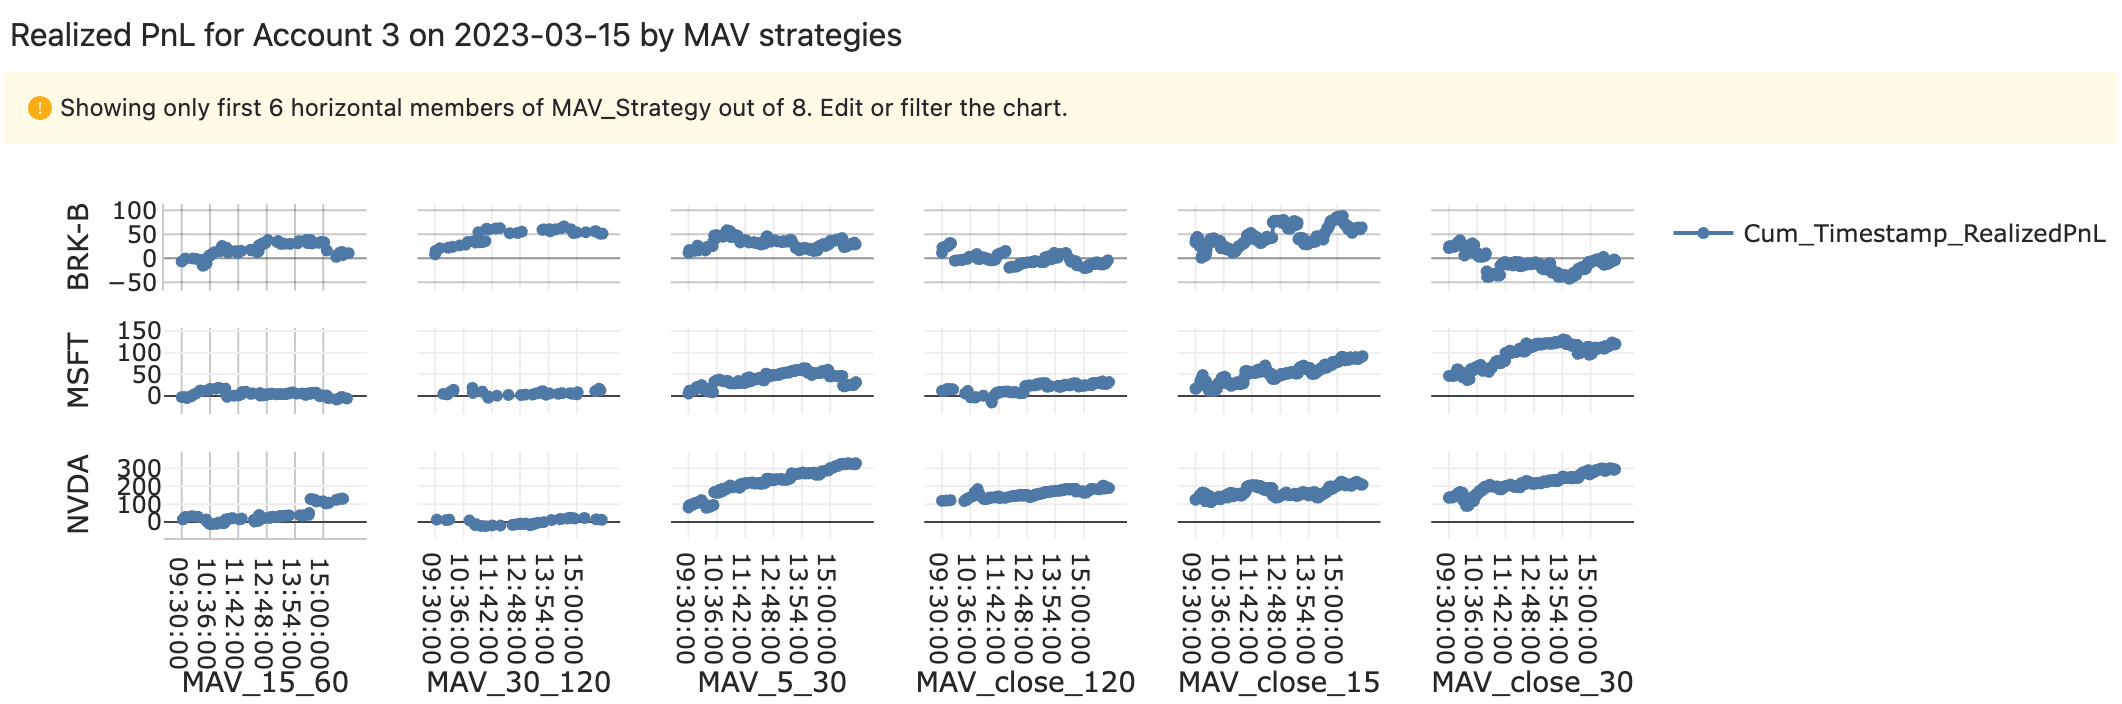

In [13]:
session.widget

We can see that the sales of `BRK-B` is causing most of the loss. Also, the strategy `MAV_15_60` and `MAV_30_120` are not performing well for `MSFT`.  

The strategies are simply different ways that the moving average is applied to obtain the buying and selling signals. These data are the outputs from our simplified trading algorithms and you can do the same with your own algorithms.

## 3. Creating Buckets

### 3.1. Date bucketing

Out-of-the-box, we are able to create [date buckets](https://docs.atoti.io/latest/lib/atoti/atoti.cube.html#atoti.Cube.create_date_hierarchy) that allow us to visualize data by different buckets such as yearly, quarterly, monthly etc. This way, we don't need to split our date column into the various buckets, saving physical data space.


In [14]:
cube.create_date_hierarchy(
    "Date hierarchy",
    column=txn_tbl["Date"],
    levels={"Year": "yyyy", "Quarter": "QQQ", "Month": "MM", "Day": "dd"},
)

The date buckets allow us to drill down on the period where performance is not ideal and see what are the contributing factors.

`ACCT4` has the lowest realized revenue compare to the other accounts. We made a loss in February. Drilling down to the day level, we can see that we made the most loss on `2023-02-13` on `AMZN`. Similarly, sorting on `GOOGL` will show that we made the most loss for the stock on `2023-02-15`.  

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
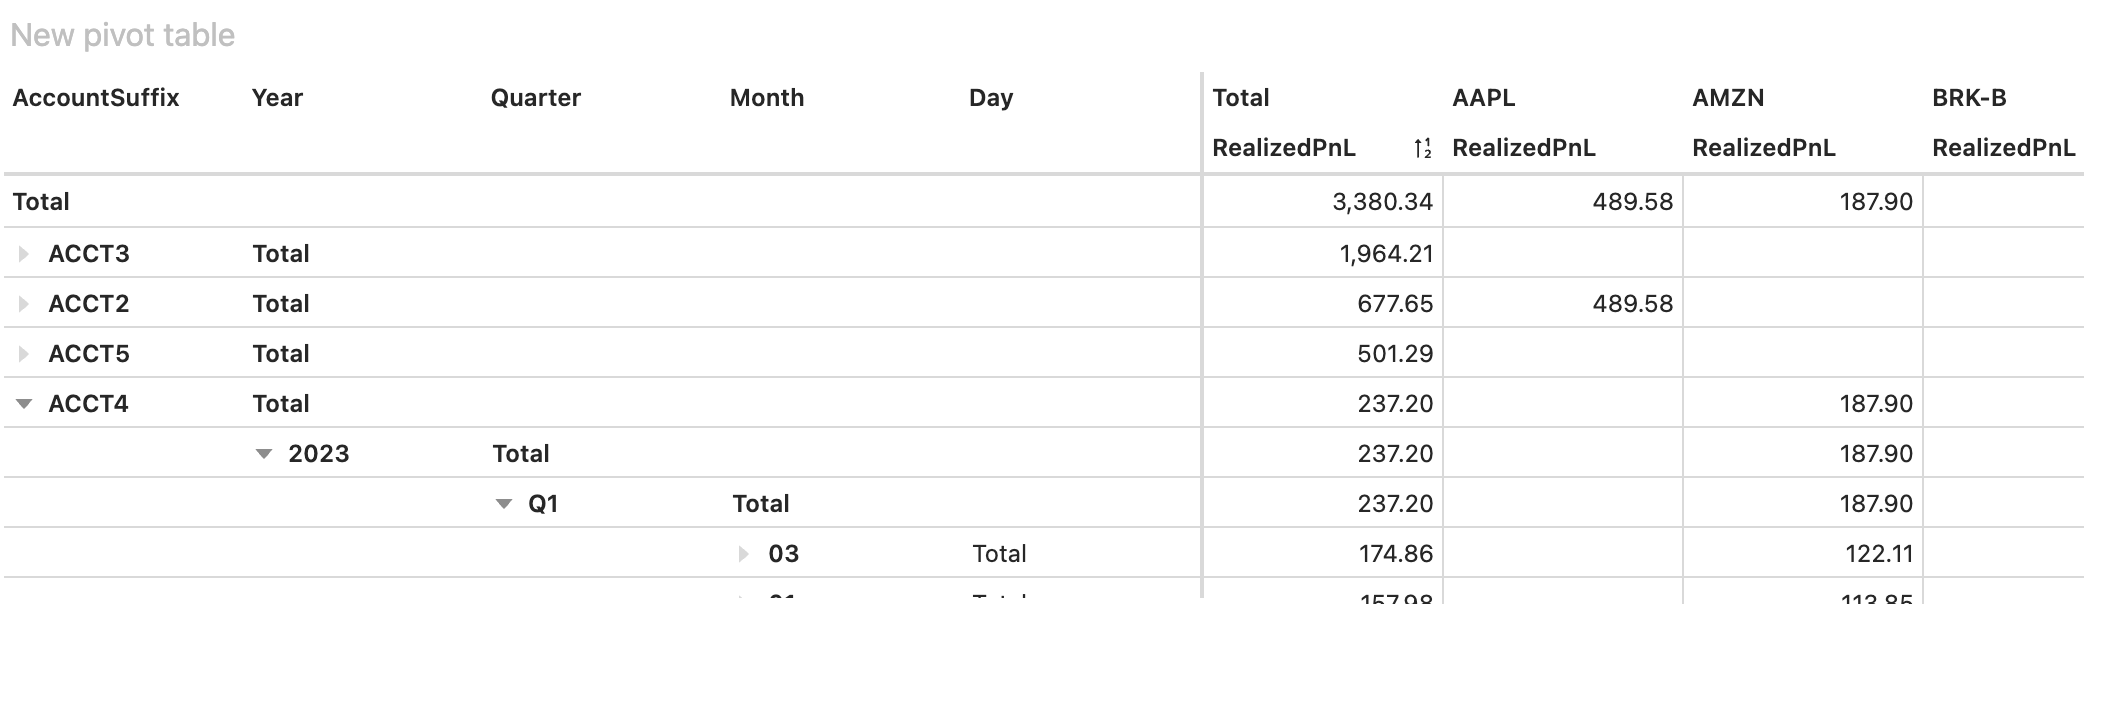

In [15]:
session.widget

### 3.2. Time bucketing

We can enrich the cube with other data sources. Tables can be joined to the base table before or after cube creation. This allows us to inject new dimensions to the cube as we draw new insights or inspirations. We generated a CSV containing bucket mapping to the trading hours of the stocks, with granularity up to the minutes. By joining the time bucket data to the base table, we can now view our data by our predefined buckets.

In [16]:
time_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/bucket-exploration/time_bucket.csv",
    table_name="TimeBucket",
    keys=["Timestamp"],
    types={
        "Timestamp": tt.type.STRING,
        "Hour": tt.type.STRING,
        "Minute": tt.type.STRING,
        "Second": tt.type.STRING,
    },
)
time_tbl.head()

,Custom_bucket,Hour,Minute,Second
Timestamp,,,,
09:42:00,[09:30-10:00),09,42,00
09:56:00,[09:30-10:00),09,56,00
10:10:00,[10:10-10:30),10,10,00
10:24:00,[10:10-10:30),10,24,00
10:38:00,[10:00-11:00),10,38,00


In [17]:
txn_tbl.join(time_tbl, txn_tbl["Timestamp"] == time_tbl["Timestamp"])
session.tables.schema

```mermaid
erDiagram
  "Transaction" {
    _ String "AccountSuffix"
    _ String PK "Ticker"
    _ String PK "DateTime"
    nullable double "TransactionPrice"
    _ String "MAV_Strategy"
    _ String "Action"
    _ String "Strategy"
    _ String "PurchaseDate"
    nullable double "PurchasePrice"
    _ String "PurchaseTxnId"
    _ String PK "TransactionId"
    _ LocalDate "Date"
    _ String "Timestamp"
  }
  "TimeBucket" {
    _ String PK "Timestamp"
    _ String "Custom_bucket"
    _ String "Hour"
    _ String "Minute"
    _ String "Second"
  }
  "Transaction" }o--o| "TimeBucket" : "`Timestamp` == `Timestamp`"
```


In [18]:
m[f"Cum_Custom_RealizedPnL"] = tt.agg.sum(
    m["RealizedPnL"], scope=tt.CumulativeScope(level=l["Custom_bucket"])
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
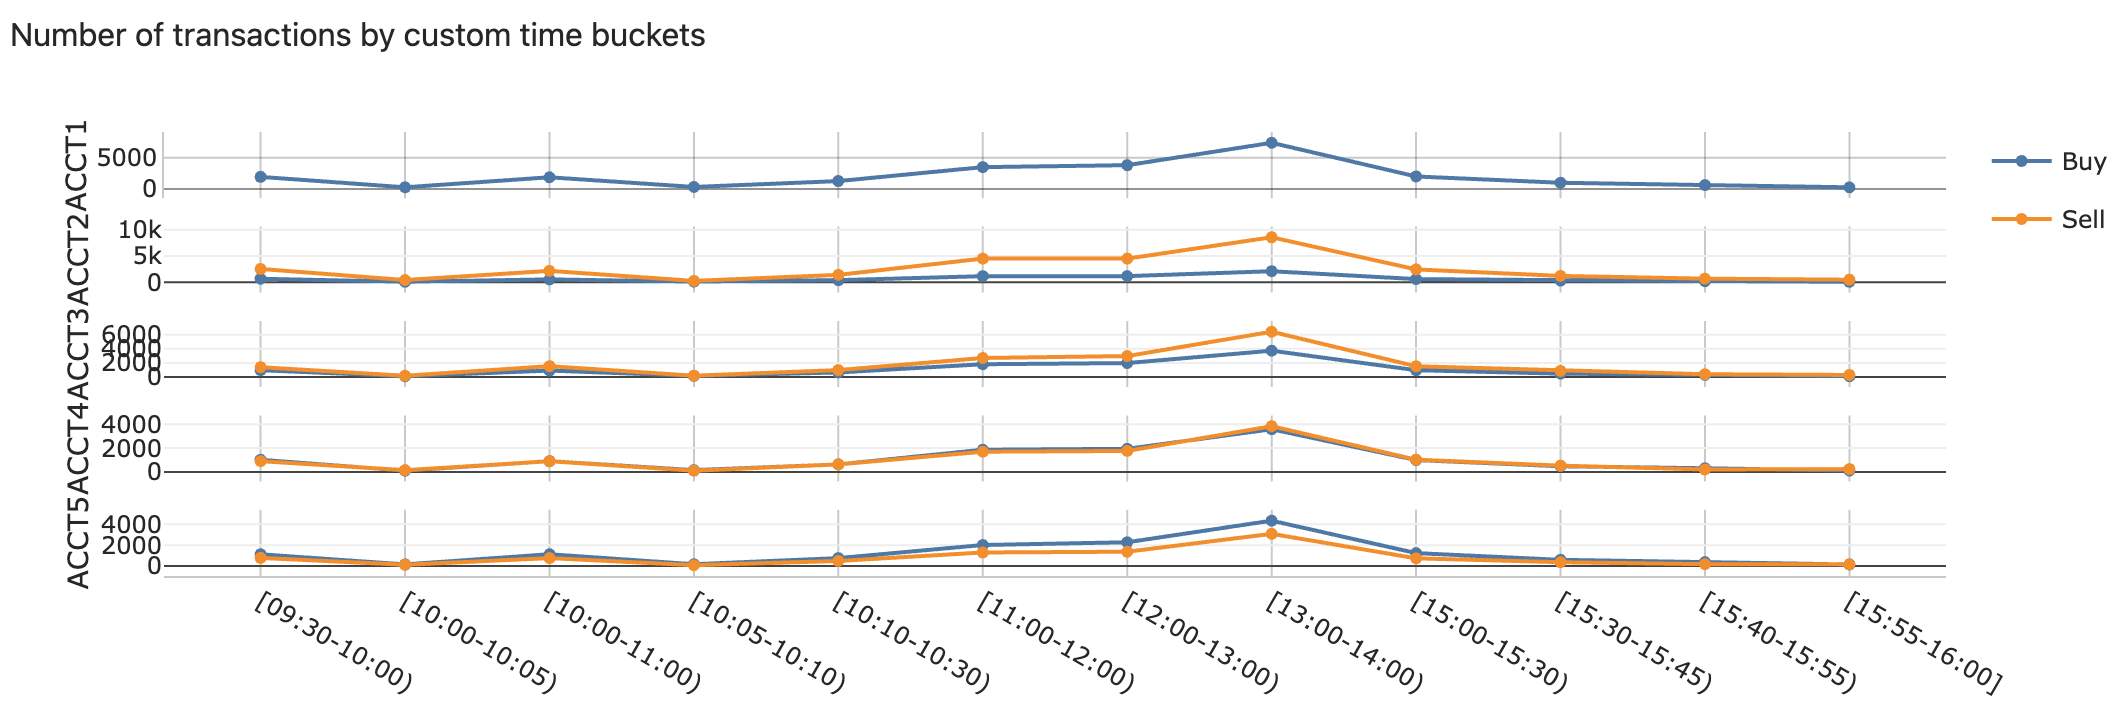

In [19]:
session.widget

### 3.3 Price Buckets

In [20]:
data_model.enrich_cube(session)
data_model.create_measures(session)

In [21]:
hist_pricing_tbl = session.tables["HistoricalPricing"]
hist_pricing_tbl.head()

,,Adj Close,Close,High,Low,Open,Volume,Price Bucket,Volume Bucket
DateTime,Ticker,,,,,,,,
2020-04-29 12:30:00,AAPL,71.790001,71.790001,72.004997,71.747475,71.795074,2503534.0,"(50, 100]","(1000000, +inf]"
2020-04-30 15:30:00,AAPL,73.6175,73.6175,73.625,72.75,72.979622,6216552.0,"(50, 100]","(1000000, +inf]"
2020-05-04 09:30:00,AAPL,72.64225,72.64225,72.866547,71.5793,72.292503,9645778.0,"(50, 100]","(1000000, +inf]"
2020-05-04 10:30:00,AAPL,72.667503,72.667503,72.805,72.339996,72.531921,3921682.0,"(50, 100]","(1000000, +inf]"
2020-05-04 11:30:00,AAPL,72.917503,72.917503,73.025002,72.675003,72.682503,3385984.0,"(50, 100]","(1000000, +inf]"


In [22]:
sector_tbl = session.tables["Sector"]
sector_tbl.head()

,Security,GICS Sector,GICS Sub-Industry
Symbols,,,
ABBV,AbbVie,Health Care,Pharmaceuticals
ALB,Albemarle Corporation,Materials,Specialty Chemicals
AEP,American Electric Power,Utilities,Electric Utilities
AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals"
BAC,Bank of America,Financials,Diversified Banks


In [23]:
session.tables.schema

```mermaid
erDiagram
  "Transaction" {
    _ String "AccountSuffix"
    _ String PK "Ticker"
    _ String PK "DateTime"
    nullable double "TransactionPrice"
    _ String "MAV_Strategy"
    _ String "Action"
    _ String "Strategy"
    _ String "PurchaseDate"
    nullable double "PurchasePrice"
    _ String "PurchaseTxnId"
    _ String PK "TransactionId"
    _ LocalDate "Date"
    _ String "Timestamp"
  }
  "HistoricalPricing" {
    _ String PK "DateTime"
    _ String PK "Ticker"
    nullable double "Adj Close"
    nullable double "Close"
    nullable double "High"
    nullable double "Low"
    nullable double "Open"
    nullable double "Volume"
    _ String "Price Bucket"
    _ String "Volume Bucket"
  }
  "Sector" {
    _ String PK "Symbols"
    _ String "Security"
    _ String "GICS Sector"
    _ String "GICS Sub-Industry"
  }
  "TimeBucket" {
    _ String PK "Timestamp"
    _ String "Custom_bucket"
    _ String "Hour"
    _ String "Minute"
    _ String "Second"
  }
  "Transaction" }o--o| "TimeBucket" : "`Timestamp` == `Timestamp`"
  "Transaction" }o--o| "HistoricalPricing" : "(`Ticker` == `Ticker`) & (`DateTime` == `DateTime`)"
  "Transaction" }o--o| "Sector" : "`Ticker` == `Symbols`"
```


Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
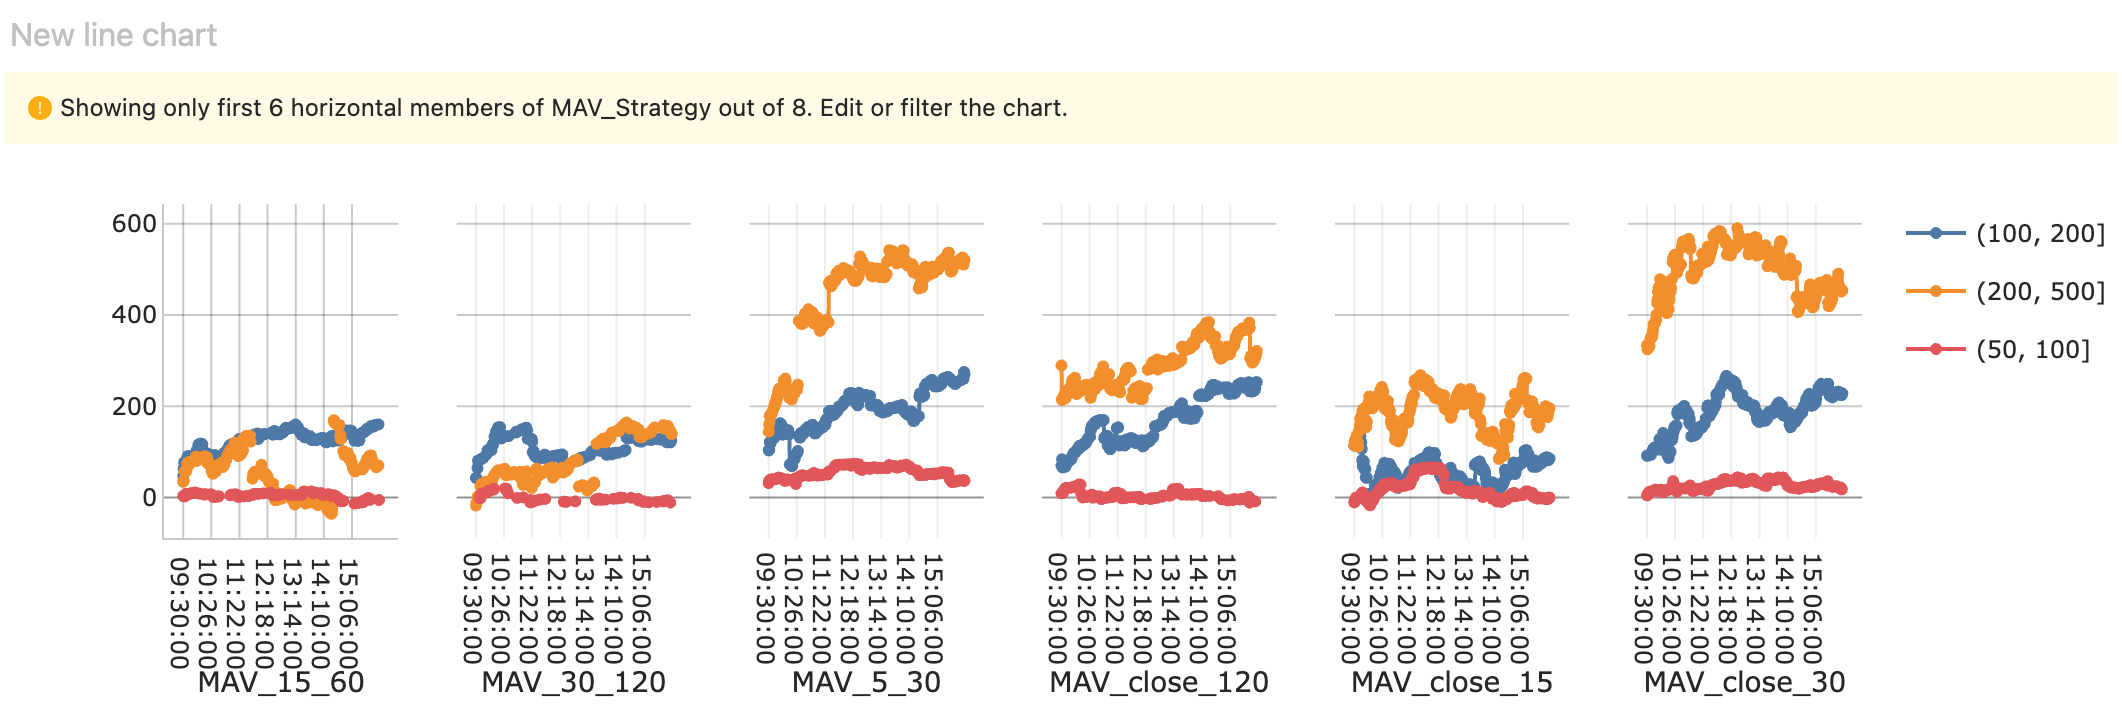

In [24]:
session.widget

## 4. Loading Additional Transactions

Once we have our data model established, we can upload the transactions of different strategies incrementally to the cube without having to restart. We can keep our train of thought without having to go back to the code base again.  

Below, we demonstrate how we can have interactive data loading in the notebook using [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/).

In [25]:
from ipywidgets import FileUpload, Output, FloatProgress
from IPython.display import display
import pandas as pd
import io

In [26]:
out = Output()
fp = FloatProgress(min=0, max=2)

In [27]:
@out.capture()
def on_upload_change(change):
    out.clear_output()
    display(fp)
    print("Uploading file for", change["new"][0].name)

    fp.value = 0
    print("- Reading file")
    input_file = list(change["new"])[0]
    content = input_file["content"]
    df = pd.read_csv(io.BytesIO(content))

    # Atoti inherits the data type from Pandas DataFrame.
    # Hence, we cast the data type before loading into the table.
    df[["DateTime", "PurchaseDate", "Timestamp"]] = df[
        ["DateTime", "PurchaseDate", "Timestamp"]
    ].astype(str)
    df["Date"] = pd.to_datetime(df["Date"]).dt.date

    print("data type of file loaded:")
    print(df.dtypes)

    fp.value = 1

    print("-- loading into transaction table")
    data_model.load_transactions(session, df)
    fp.value = 2

    displayFileLoader()

In [28]:
def displayFileLoader():
    uploader = widgets.FileUpload(
        accept=".csv",
        multiple=False,
    )

    uploader.observe(on_upload_change, "value")
    with out:
        display(uploader)

We will be able to load new transaction data for the cube as long as it follows the same columns and their data types.  
Download this [sample transaction file](https://data.atoti.io/notebooks/bucket-exploration/transactions_c.csv) and try loading it with the below function.

In [30]:
displayFileLoader()
out

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': 'FloatProgress(value=0.0, max=2.0)', 'a…

We are now able to access the latest data!  

If you are loading the [sample transaction file](https://data.atoti.io/notebooks/bucket-exploration/transactions_c.csv) provided, switch the below cell to code and run it to see the difference between the two strategy.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
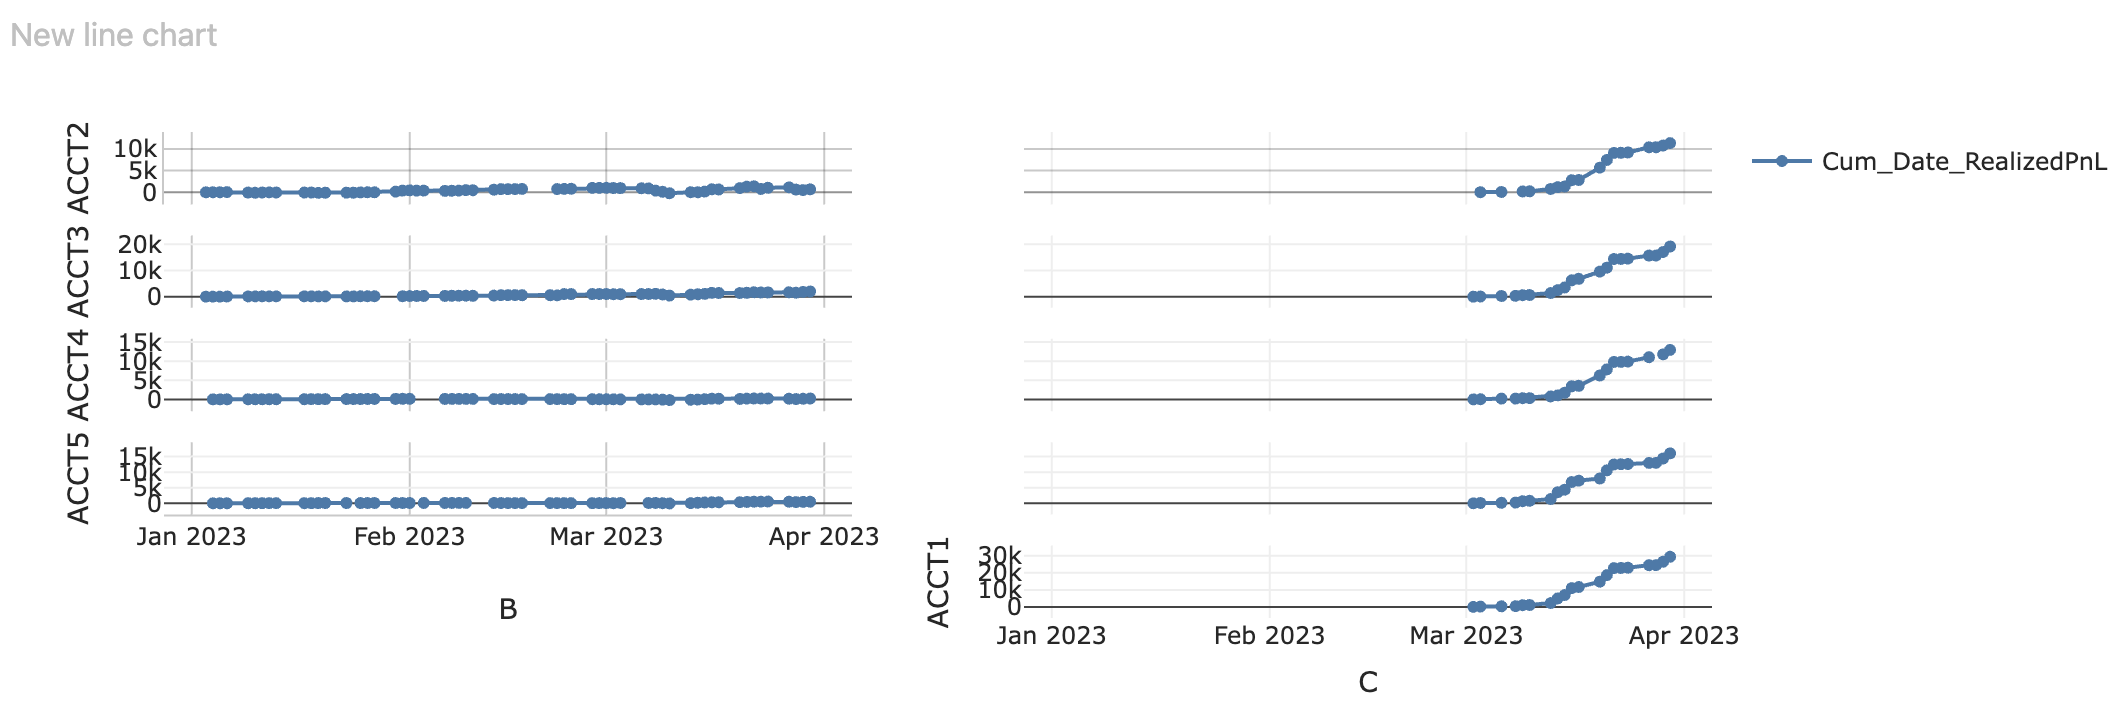

In [31]:
session.widget

## 5. Interactive exploration

Access the below dashboard to see how we can permutate across different dimensions to gather different insights. Play with the filters to dive in a particular account, sector or strategy!

In [32]:
session.link / "#/dashboard/11d"

http://localhost:9092/#/dashboard/11d

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=buckets" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try atoti"></a></div>